
# NAM Project - *Team 12*

# **Polypharmacy side-effect Association Network Analysis**

Team Members:
* Abhishek V   -  PES2UG19CS012
* Balendra DP  -  PES2UG19CS100
* Ujwal Kundur -  PES2UG19CS197
* Kuntal Gorai -  PES2UG19CS198 


## Table of Contents

1. [Introduction and Problem Statement](#intro)
2. [Data IO and Graph Creation](#io)
3. [Exploratory Data Analysis](#eda)
4. [Graph Metrics](#metrics)
5. [Link Prediction and Analysis using Tradional Similarity based Techniques](#mltrad)
6. [Link Prediction and Analysis using Graph ML Techniques](#ml)
7. [Conclusion and Report](#report)

## 1. Introduction <a name="intro"></a>

This is a network of polypharmacy side-effects. <br>
Nodes represent drugs and edges represent different types of side effects that are associated with drug pairs. <br> 
Edges indicate which side effects a patient will likely experience if he takes two drugs together (i.e., a drug combination). Such side effects are known as **polypharmacy side-effects**, as they are associated with drug pairs (or higher-order drug combinations) and cannot be attributed to either individual drug in the pair (in a drug combination).

## 2. Data IO and Graph Creation <a name="io"></a>

In [ ]:
# Standard Imports

import numpy as np
import pandas as pd
import requests
import json
import random

import multiprocessing
import os
from math import isclose
from collections import Counter

import networkx as nx

# Plotting Libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px

# ML Libraries
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, auc, log_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

!pip install stellargraph
!pip install gensim

from IPython.display import display, HTML
%matplotlib inline


In [ ]:
data = pd.read_csv('http://snap.stanford.edu/biodata/datasets/10017/files/ChChSe-Decagon_polypharmacy.csv.gz')

# Captialize Words
data["Side Effect Name"] = data["Side Effect Name"].apply(str.title)

data.head()

,# STITCH 1,STITCH 2,Polypharmacy Side Effect,Side Effect Name
0,CID000002173,CID000003345,C0151714,Hypermagnesemia
1,CID000002173,CID000003345,C0035344,Retinopathy Of Prematurity
2,CID000002173,CID000003345,C0004144,Atelectasis
3,CID000002173,CID000003345,C0002063,Alkalosis
4,CID000002173,CID000003345,C0004604,Back Ache


In [ ]:
# Take 0.5% of data for testing

per = 0.005
rows = int(data.shape[0] * per)
tdata = data.iloc[:rows,:]
tdata = tdata.drop('Polypharmacy Side Effect', axis=1)

print("Original Data:", data.shape, "\nResampled Data:", tdata.shape)

Original Data: (4649441, 4) 
Resampled Data: (23247, 3)


In [ ]:
# CID mappings to drug names
url = 'https://raw.githubusercontent.com/kuntal0901/NAM_Project/main/CID_Mappings.json'
resp = requests.get(url)
cid_mappings = json.loads(resp.text)
print(cid_mappings)

{'CID000002173': '6-{[Amino(phenyl)acetyl]amino}-3,3-dimethyl-7-oxo-4-thia-1-azabicyclo[3.2.0]heptane-2-carboxylate', 'CID000005206': 'Sevoflurane', 'CID000003929': 'N-[[(5S)-3-[3-Fluoro-4-(4-morpholinyl)phenyl]-2-oxo-5-oxazolidinyl]methyl]-acetamide', 'CID000001302': '2-(6-Methoxy-2-naphthyl)propionic acid', 'CID000005267': 'Duraspiron', 'CID000004601': 'Orphenadrine', 'CID000005090': 'Rofecoxib', 'CID000004946': 'Propranolol', 'CID000005391': 'Temazepam', 'CID000002802': 'Clonazepam', 'CID000004212': 'Mitoxantrone', 'CID000000596': 'Depocyt', 'CID000002522': '5-[2-[1-(5-Cyclopropyl-5-hydroxypent-3-en-2-yl)-7a-methyl-2,3,3a,5,6,7-hexahydro-1H-inden-4-ylidene]ethylidene]-4-methylenecyclohexane-1,3-diol', 'CID000003405': 'CID 3405', 'CID000003446': 'Gabapentin', 'CID000004107': 'Methocarbamol', 'CID000003161': 'CID 3161', 'CID000003823': 'Ketoconazole', 'CID000005556': 'Triazolam', 'CID000002156': '[2-[4-[(2-Butylbenzofuran-3-yl)carbonyl]-2,6-diiodophenoxy]ethyl]diethylaminium', 'CID000

In [ ]:
# Create Graph from Data
G = nx.Graph()

# Add Edges (and therefore Nodes)
tdata.apply(lambda row: G.add_edge(row[0], row[1], side_effect=row[2]), axis=1)

print(G.edges(data=True))
print(G.nodes(data=True))

# Why is this different?
print(len(tdata.iloc[:,0].unique())+len(tdata.iloc[:,1].unique()), len(G.nodes()))


[('CID000002173', 'CID000003345', {'side_effect': 'Patent Ductus Arteriosis'}), ('CID000003345', 'CID000002907', {'side_effect': 'Leucocytosis'}), ('CID000003345', 'CID000060843', {'side_effect': 'Leucopenia'}), ('CID000003345', 'CID000003367', {'side_effect': 'Fungal Disease'}), ('CID000005206', 'CID000009433', {'side_effect': 'Anaphylactic Reaction'}), ('CID000003929', 'CID000150610', {'side_effect': 'Head Ache'}), ('CID000001302', 'CID000005064', {'side_effect': 'Head Ache'}), ('CID000001302', 'CID000004893', {'side_effect': 'Disorder Retinal'}), ('CID000001302', 'CID000004894', {'side_effect': 'Head Ache'}), ('CID000001302', 'CID000002802', {'side_effect': 'Head Ache'}), ('CID000001302', 'CID000002803', {'side_effect': 'Head Ache'}), ('CID000001302', 'CID000002800', {'side_effect': 'Still Birth'}), ('CID000001302', 'CID000002806', {'side_effect': 'Head Ache'}), ('CID000001302', 'CID000004075', {'side_effect': 'Feeling Unwell'}), ('CID000001302', 'CID000003869', {'side_effect': 'Fib

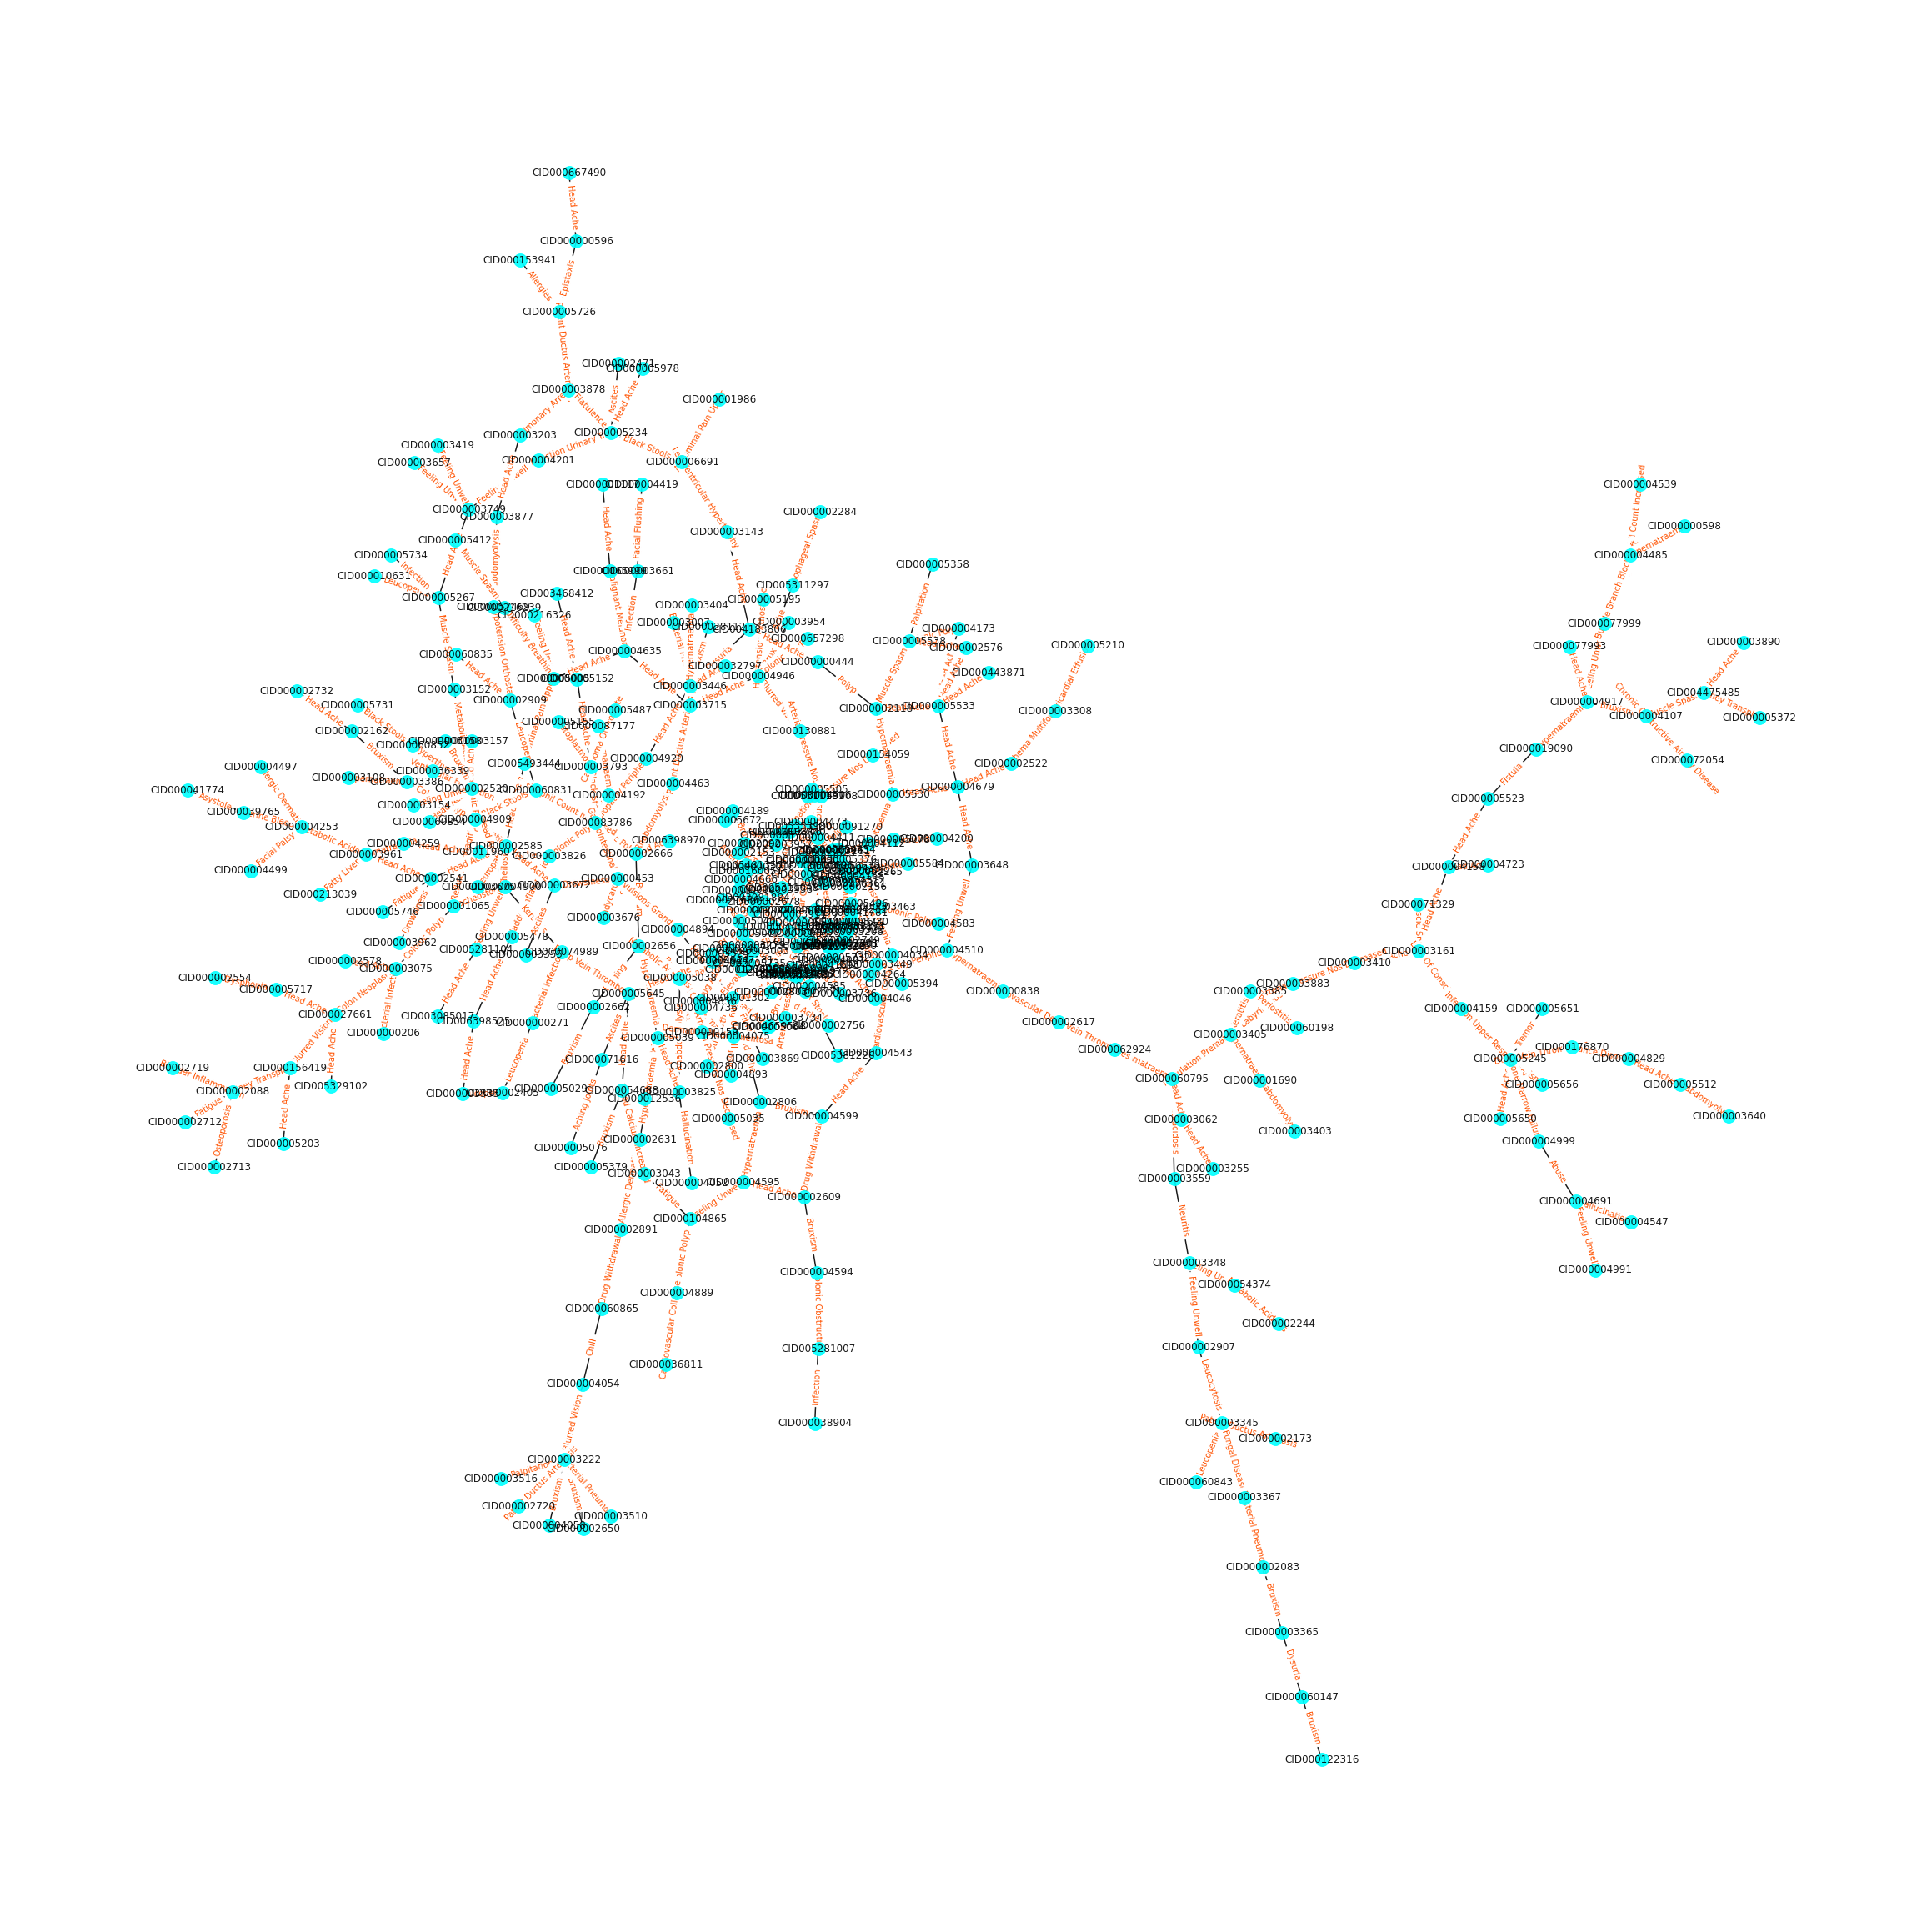

In [ ]:
def draw_graph(G, attr='side_effect'):
  """ Utility Function to draw pretty graphs """
  pos = nx.kamada_kawai_layout(G)
  plt.figure(figsize=(32,32))
  nx.draw(
      G, pos, edge_color='black', width=1.5, linewidths=1,
      node_size=250, node_color='cyan', alpha=0.9,
      labels={node: node for node in G.nodes()}
  )
  edge_labels = {(i[0],i[1]) : i[2][attr] for i in G.edges(data=True)}
  nx.draw_networkx_edge_labels(
      G, pos,
      edge_labels=edge_labels,
      font_color=(1, 0.32, 0)
  )
  plt.axis('off')
  plt.show()

draw_graph(G)

## 3. EDA <a name="eda"></a>

In [ ]:
# Utility Functions

def find_nodes_causing_sideeffect(name):
  name_res = tdata.loc[tdata['Side Effect Name'] == name]
  name_res = name_res.iloc[:, :2]
  return name_res.reset_index(drop=True)

def find_top_drugs_causing_effect(name, topk=5):
  res = find_nodes_causing_sideeffect(name)
  return dict(res.value_counts())

# A function used for sorting values based on score used in sorting centrality measures
def sort_and_display_scores(vals, cols=['Node/Edge', 'Score']):
  sorted_dict = sorted(vals.items(), key=lambda x: x[1], reverse=True)
  df = pd.DataFrame(sorted_dict, columns=cols)
  return df


In [ ]:
# Check if the graph is bipartite
from networkx.algorithms import bipartite

print(bipartite.is_bipartite(G))

False


In [ ]:
se_counts = tdata["Side Effect Name"].value_counts()
se_counts = se_counts.rename_axis('Side Effect Name').reset_index(name='Counts')
se_counts.iloc[:10,:]

,Side Effect Name,Counts
0,Difficulty Breathing,147
1,Arterial Pressure Nos Decreased,145
2,Nausea,141
3,Neumonia,136
4,Pain,131
5,Anaemia,128
6,Hypoventilation,127
7,Emesis,126
8,Fatigue,123
9,Dizziness,121


In [ ]:
fig = px.bar(tdata["Side Effect Name"].value_counts())
fig.show()

We can see that the top 3 side effects are:
* *Difficulty Breathing*
* *Arterial Pressure Decrease*
* *Nausea*

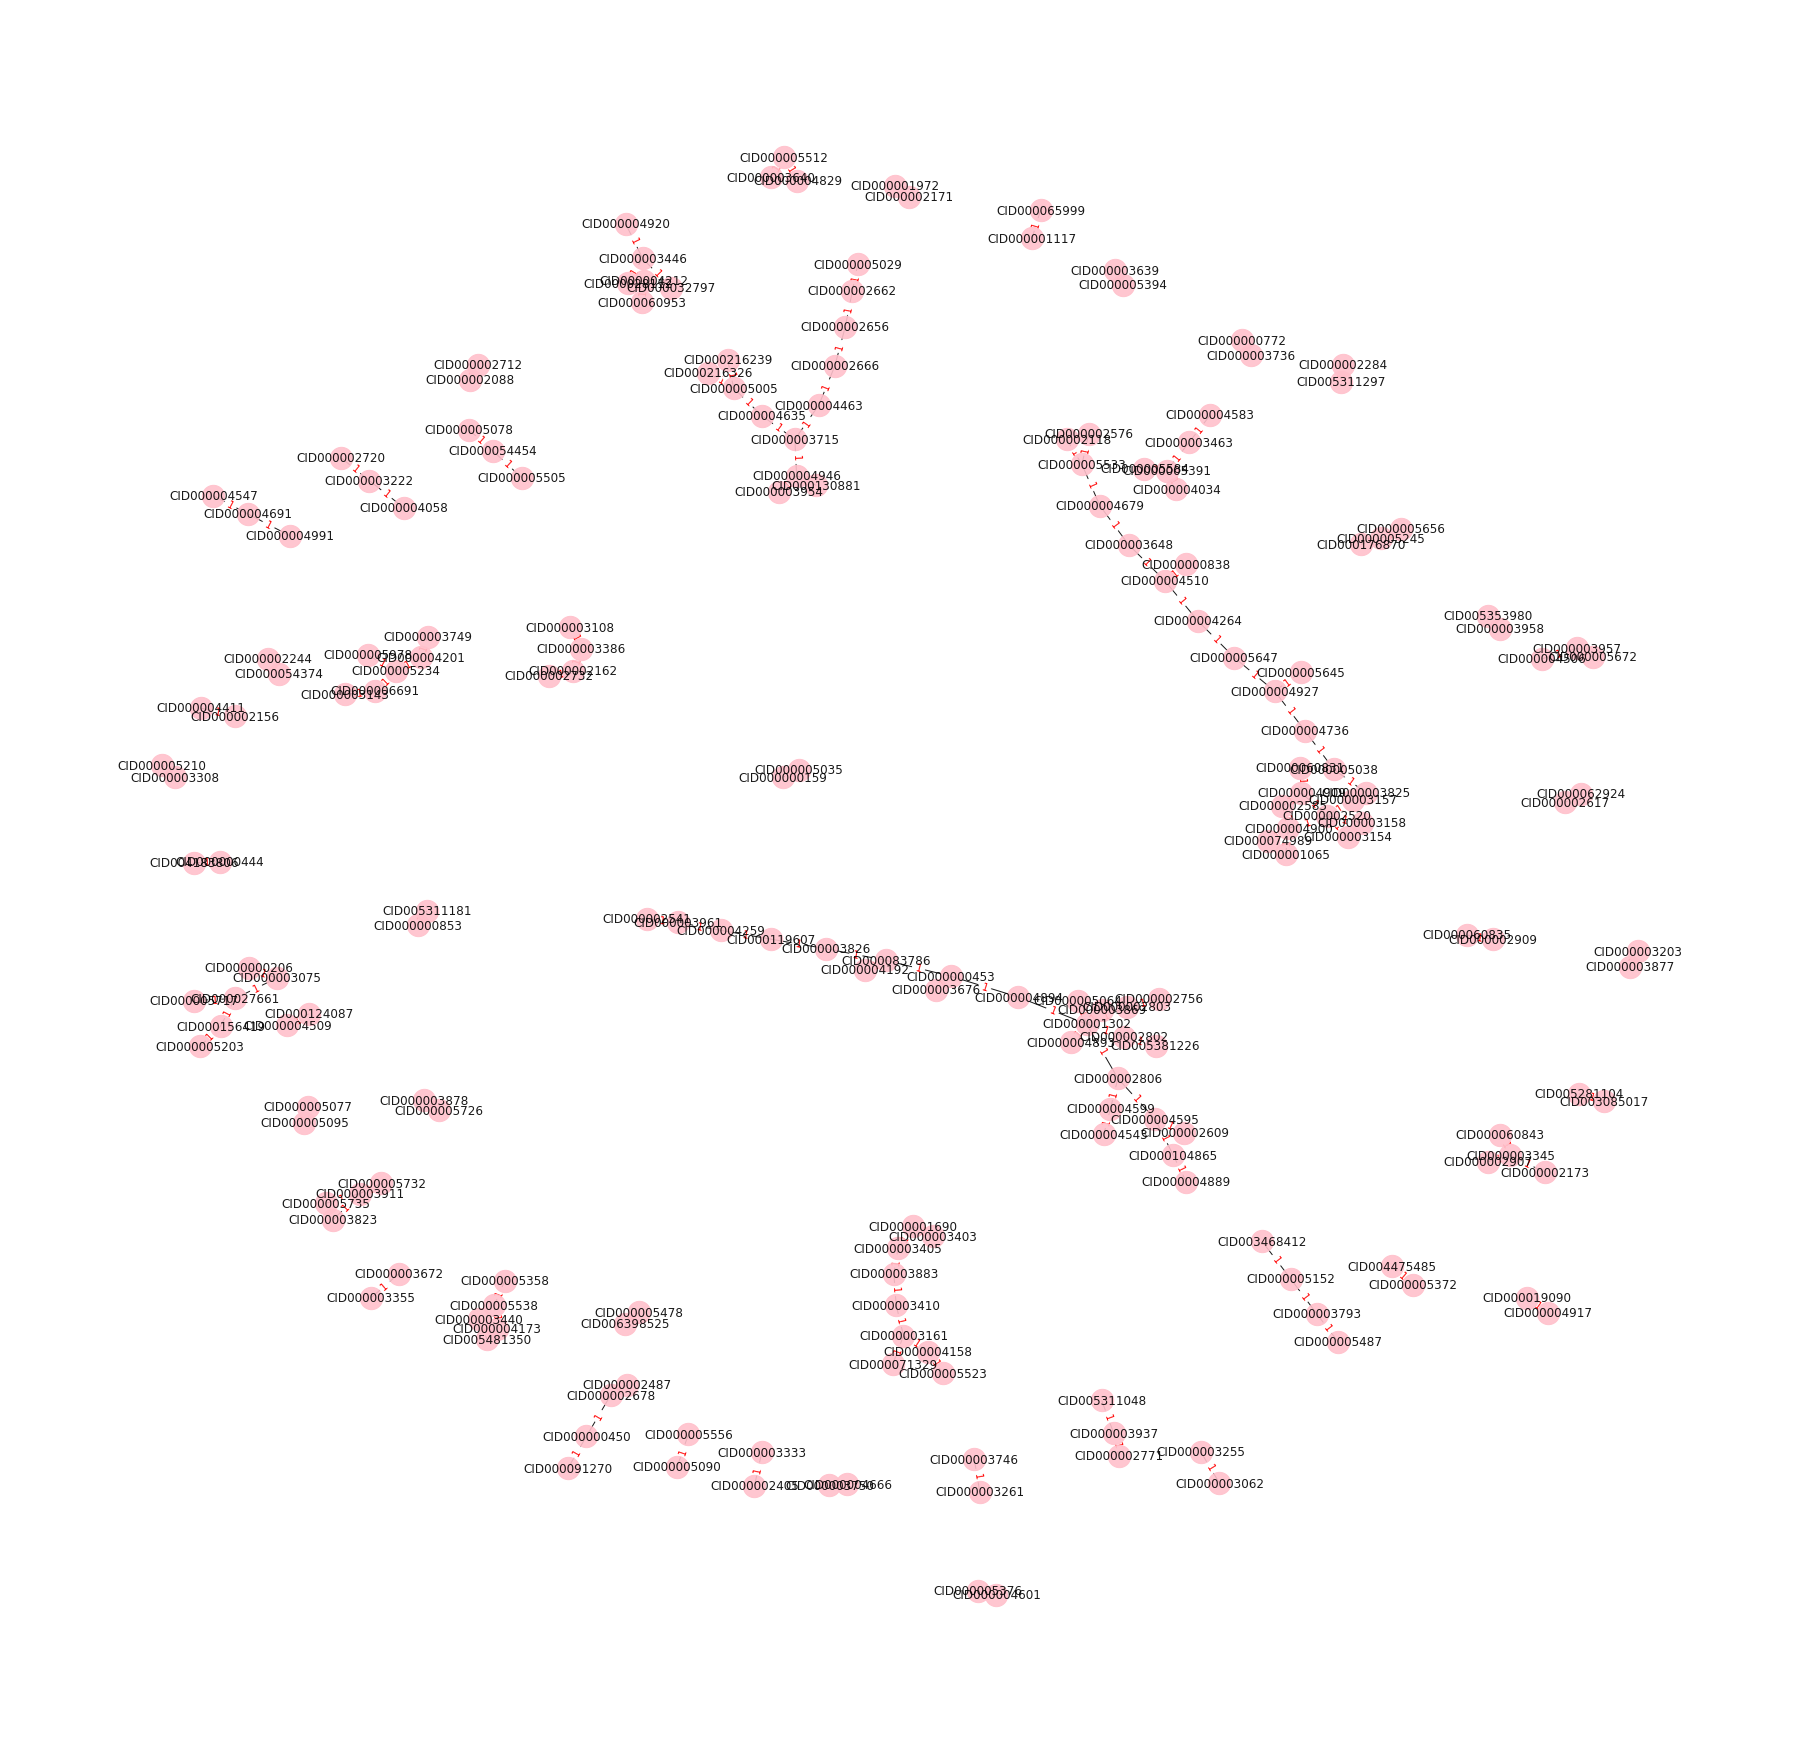

In [ ]:
db = find_top_drugs_causing_effect("Difficulty Breathing")
side_graph = nx.Graph()
for i in db:
  side_graph.add_edge(i[0], i[1], count=db[i])

pos = nx.spring_layout(side_graph)
plt.figure(figsize=(32,32))
plt.axis('off')
nx.draw(
    side_graph, pos, edge_color='black', width=1, linewidths=1,
    node_size=500, node_color='pink', alpha=0.9,
    labels={node: node for node in side_graph.nodes()}
)
edge_labels = {(i[0],i[1]) : i[2]['count'] for i in side_graph.edges(data=True)}
nx.draw_networkx_edge_labels(
    side_graph, pos,
    edge_labels=edge_labels,
    font_color='red'
)
plt.show()


This is a graph of the interactions between the drugs causing a polypharmacy side-effect of *Difficulty in Breathing*

The drug combinations most reponsible for the top 3 side-effects are:



In [ ]:
nausea = find_nodes_causing_sideeffect("Nausea")
db = find_nodes_causing_sideeffect("Difficulty Breathing")
art = find_nodes_causing_sideeffect("Arterial Pressure Nos Decreased")

# Get Common Drug Combinations
commons = nausea.merge(db).merge(art)
commons.iloc[:10, :]

,# STITCH 1,STITCH 2
0,CID000005391,CID000005584
1,CID000003937,CID005311048
2,CID000004158,CID000005523
3,CID000003826,CID000083786
4,CID000004736,CID000005038
5,CID000003261,CID000003746
6,CID000003446,CID000028112
7,CID000002162,CID000003386
8,CID000003075,CID000027661
9,CID000004543,CID000004599


## 4. Graph Metrics <a name="metrics"></a>

In [ ]:
def calc_centralities(graph):
    
    dgc = nx.degree_centrality(graph)
    dgc = pd.DataFrame.from_dict(dgc, orient='index', columns=["DGC"])
    btc = nx.betweenness_centrality(graph)
    btc = pd.DataFrame.from_dict(btc, orient='index', columns=["BTC"])
    cc = nx.closeness_centrality(graph)
    cc = pd.DataFrame.from_dict(cc, orient='index', columns=["CC"])


    df = pd.concat([dgc, btc,cc], axis=1)
    
    return df

cgraph = nx.Graph()
tdata.apply(lambda row: cgraph.add_edge(cid_mappings[row[0]], cid_mappings[row[1]], side_effect=row[2]), axis=1)
df_cent = calc_centralities(cgraph)
df_cent

,DGC,BTC,CC
"6-{[Amino(phenyl)acetyl]amino}-3,3-dimethyl-7-oxo-4-thia-1-azabicyclo[3.2.0]heptane-2-carboxylate",0.002915,0.000000,0.048429
Fentanyl,0.011662,0.029427,0.051832
Sevoflurane,0.002915,0.000000,0.002915
Aminophylline,0.002915,0.000000,0.002915
N-[[(5S)-3-[3-Fluoro-4-(4-morpholinyl)phenyl]-2-oxo-5-oxazolidinyl]methyl]-acetamide,0.002915,0.000000,0.002915
...,...,...,...
Ciclopirox,0.002915,0.000000,0.002915
Metoclopramide,0.002915,0.000000,0.002915
Chlorothiazide,0.002915,0.000000,0.053463
Solifenacin,0.002915,0.000000,0.077079


In [ ]:
# Node Betweenes centrality
bet_cent = nx.betweenness_centrality(cgraph)
sort_and_display_scores(bet_cent, cols=['Drug', 'Betweeness Centrality'])

,Drug,Betweeness Centrality
0,Nitroglycerin,0.192225
1,Aripiprazole,0.187220
2,Adrenaline,0.184731
3,CID 5647,0.182766
4,"3-{[(5-Methyl-1,3,4-thiadiazol-2-yl)sulfanyl]m...",0.182292
...,...,...
339,Ciclopirox,0.000000
340,Metoclopramide,0.000000
341,Chlorothiazide,0.000000
342,Solifenacin,0.000000


**Analysis** -  The drug Nitroglycerin  has highest betweeness centrality i.e it has highest amount of influence for flow of sideffects in a graph.

In [ ]:
# Edge betweeness Centrality
ebet_cent = nx.edge_betweenness_centrality(cgraph)
sort_and_display_scores(ebet_cent, cols=['Edge', 'Edge Betweeness Centrality'])

,Edge,Edge Betweeness Centrality
0,"(Adrenaline, Nitroglycerin)",0.186996
1,"(Adrenaline, 3-{[(5-Methyl-1,3,4-thiadiazol-2-...",0.184589
2,"(3-{[(5-Methyl-1,3,4-thiadiazol-2-yl)sulfanyl]...",0.182148
3,"(Aripiprazole, S-(Fluoromethyl) (6S,9R,10S,11S...",0.179673
4,"(CID 5647, 9-[4-[3,4-Dihydroxy-5-[[3-(3-hydrox...",0.156101
...,...,...
333,"(Sufentanil, Torsemide)",0.000017
334,"(Metformin, Nebramycin factor 6)",0.000017
335,(7-[4-[Anilino(oxo)methyl]-2-(4-fluorophenyl)-...,0.000017
336,"(Clomipramine, Oxcarbazepine)",0.000017


**Analysis**- The number of shortest paths between vertices that contain the edge Adrenaline and Nitroglycerin is highest

In [ ]:
# Degree Centrality
deg_cent = nx.degree_centrality(cgraph)
sort_and_display_scores(deg_cent, cols=['Drug', 'Degree Centrality'])

,Drug,Degree Centrality
0,2-(6-Methoxy-2-naphthyl)propionic acid,0.026239
1,Verapamil,0.026239
2,CID 83786,0.020408
3,Propranolol,0.017493
4,Temazepam,0.017493
...,...,...
339,Ciclopirox,0.002915
340,Metoclopramide,0.002915
341,Chlorothiazide,0.002915
342,Solifenacin,0.002915


**Analysis** - The node 2-(6-Methoxy-2-naphthyl)propionic acid (Common drug name : **Naproxen** )	and Verapamil has a larger than average number of connenctions for this graph.

In [ ]:
# Eigen Centrality
pg_rank = nx.pagerank(cgraph)
sort_and_display_scores(pg_rank, cols=["Drug", "Page Rank"])

,Drug,Page Rank
0,Verapamil,0.010784
1,2-(6-Methoxy-2-naphthyl)propionic acid,0.010148
2,Heparin,0.009594
3,1-(2-{[1-(Ethoxycarbonyl)-3-phenylpropyl]amino...,0.008826
4,Risedronic acid,0.008036
...,...,...
339,Phenelzine,0.001365
340,Raloxifene,0.001362
341,Trimipramine,0.001356
342,"(2R)-3-Phenyl-2-[[(1S,3S)-3-propan-2-ylcyclohe...",0.001345


**Analysis** - The drug verapamil has the highest influence in the given network

In [ ]:
class SpecClust:

  def __init__(self, graph, n_clusters=8):
    self.graph = graph
    self.n_clusters = n_clusters

    # Fit Data
    normalized_laplacian = nx.linalg.normalized_laplacian_matrix(self.graph).toarray()
    clustering = SpectralClustering(n_clusters=n_clusters)
    clustering.fit(normalized_laplacian)

    # Label Predictions
    labels = clustering.labels_
    self.labels = labels

    # Assign Labels
    for i,node in enumerate(self.graph.nodes()):
      self.graph.nodes[node]['label'] = labels[i]

  # Plot the Graph
  def plot(self, title='Graph after Spectral Clustering'):

    colour_list = ['blue','green','red','yellow','cyan', 'magenta','lightblue','grey']
    sampled_colours = dict(zip(set(self.labels),random.sample(colour_list, self.n_clusters)))

    legend_handles = []
    for label, color in sampled_colours.items():
        colour_handle = mpatches.Patch(color=color, label=label)
        legend_handles.append(colour_handle)

    colours = [sampled_colours[i] for i in self.labels]

    pos_fr = nx.kamada_kawai_layout(self.graph)
    plt.figure(figsize=(18,18))
    plt.title(title)
    plt.legend(handles=legend_handles)
    nx.draw(self.graph, pos=pos_fr, node_size=250, node_color=colours, with_labels=True)
    plt.show()



/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_spectral.py:590: UserWarning:

The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.



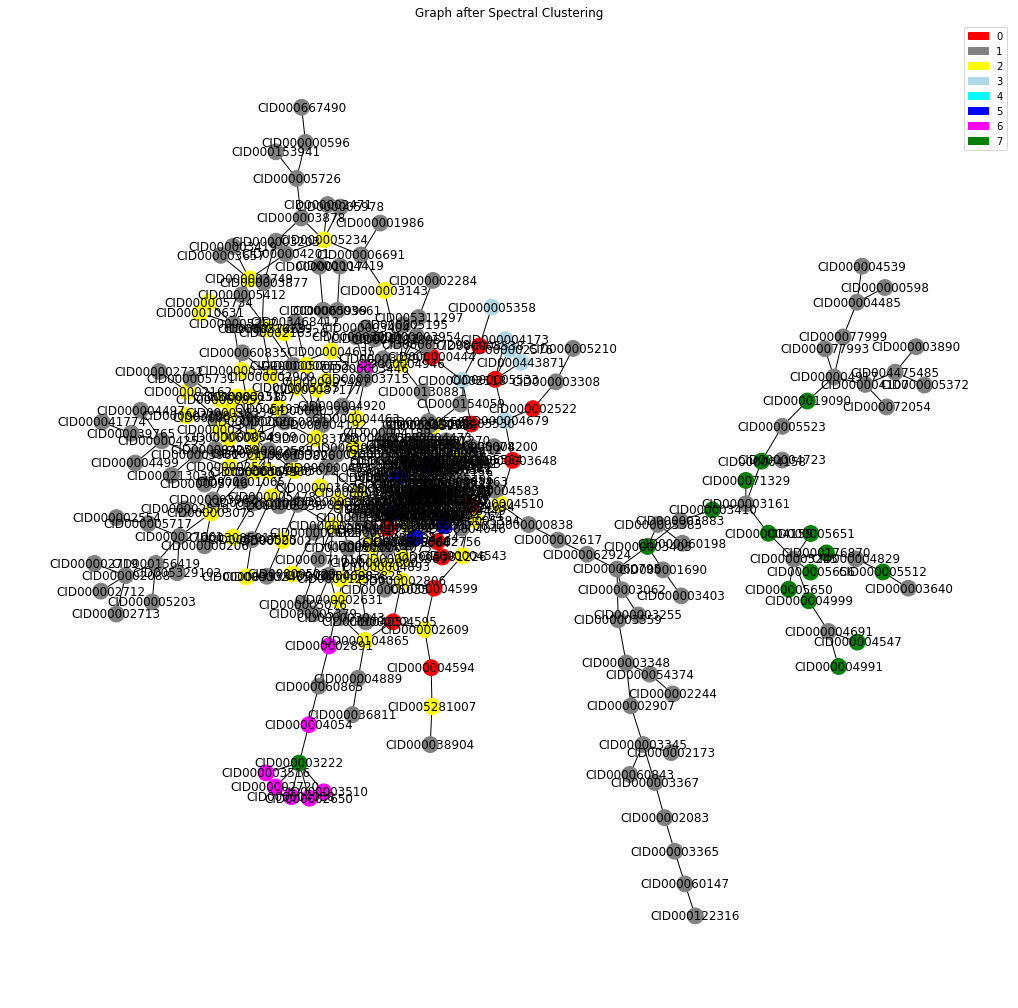

In [ ]:
# Defaults to 8 clusters as per sklearn
specg = SpecClust(G)
specg.plot()

**Analysis** - We see that using spectral clustering we were able to classify our graph into 8 different communities.This helps in finding similarites among nodes is high if they are belonging to the same community

## 5. Link Prediction and Analysis using Traditional Similarity based methods <a name="mltrad"></a>

**Preprocessing on Graph for Link Prediction**

In [ ]:
# Take a random sample of edges
n,m = G.number_of_nodes(),G.number_of_edges()
propotion_edges = 0.05
edge_subset = random.sample(G.edges(),int(propotion_edges*G.number_of_edges()))

# Removing some edges.The goal is to try and reperedict these edges and measure how close the prediction is to orignal
G_train = G.copy()
G_train.remove_edges_from(edge_subset)

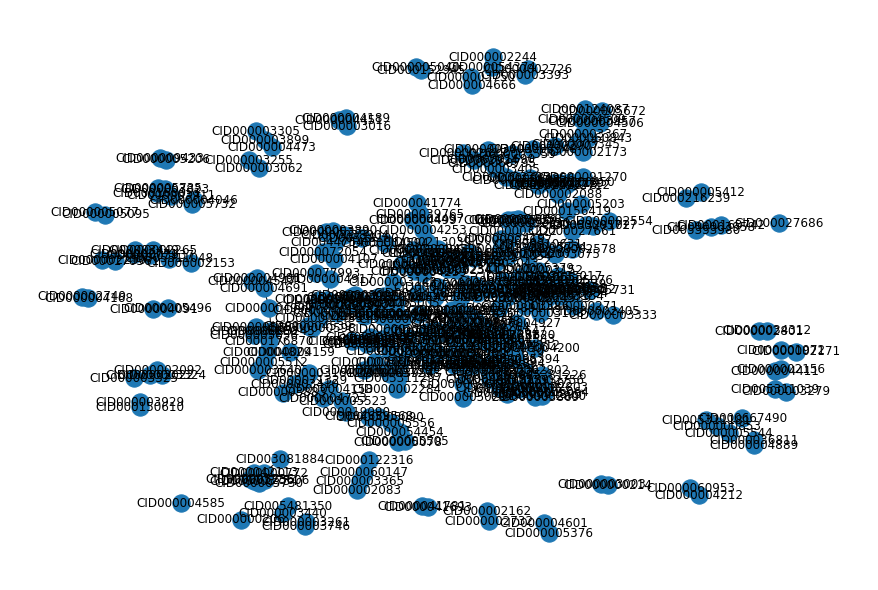

In [ ]:
plt.figure(figsize=(12,8))
nx.draw(G_train,with_labels = True)

### **First Approach - Proximity Based Likelihood Approach**

### **Jaccard Coefficent**

$$S_j(i, j) = \frac {| N(i)\ \cap \ N(j)|}{|N(i)\ \cup \ N(j)|}$$
Where, $S_j(i, j)$ is the Jaccard coefficient for vertices $i$ and $j$.

In [ ]:
# calculating jaccard coefficient for all the node pairs in G_train.

prediction_jaccard = list(nx.jaccard_coefficient(G_train))
score_jaccard, label_jaccard = zip(*[(s, (u,v) in edge_subset) for (u,v,s) in prediction_jaccard])


In [ ]:
# binary classification here. taking various thresholds for the jaccard coefficient.
# calculating fpr, tpr, and auc values for various thresholds of the jaccard coefficient.

fpr_jaccard, tpr_jaccard, thresholds_jaccard = roc_curve(label_jaccard, score_jaccard)
auc_jaccard = roc_auc_score(label_jaccard, score_jaccard)

### **Adamic-Adar Similarity**

$$ S_a(i, j) = \sum_{k\ \in\ N(i)\ \cap\ N(j)} \frac{1}{log|N(k)|} $$
Where $S_a(i, j)$ is the Adamic-Adar similarity measure for vertices $i$ and $j$.

In [ ]:
# calculating Adamic-Adar Similarity for all the node pairs in G_train.
prediction_adamic = list(nx.adamic_adar_index(G_train))
score_adamic, label_adamic = zip(*[(s, (u,v) in edge_subset) for (u,v,s) in prediction_adamic])

In [ ]:
# binary classification here. taking various thresholds for the Adamic-Adar Similarity.
# calculating fpr, tpr, and auc values for various thresholds of the Adamic-Adar Similarity.
fpr_adamic, tpr_adamic, thresholds_adamic = roc_curve(label_adamic, score_adamic)
auc_adamic = roc_auc_score(label_adamic, score_adamic)

### **Prefential Attachment**

$$ S_p(i, j) = |N(i)|\ \cdot\ |N(j)| $$
Where, $S_p(i, j)$ is the preferential attachment measure between vertices $i$ and $j$ according the the Barabási-Albert model of preferential attachment.

In [ ]:
# calculating Prefential Attachment for all the node pairs in G_train.
prediction_pref = list(nx.preferential_attachment(G_train))
score_pref, label_pref = zip(*[(s, (u,v) in edge_subset) for (u,v,s) in prediction_pref])

In [ ]:
# binary classification here. taking various thresholds for the Prefential Attachment.
# calculating fpr, tpr, and auc values for various thresholds of the Prefential Attachment.
fpr_pref, tpr_pref, thresholds_pref = roc_curve(label_pref, score_pref)
auc_pref = roc_auc_score(label_pref, score_pref)

### **Plotting ROC AUC Curve**

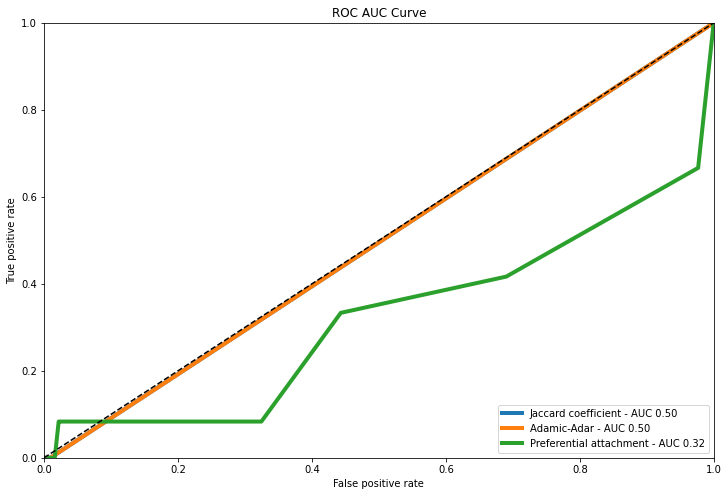

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(fpr_jaccard, tpr_jaccard, label='Jaccard coefficient - AUC %.2f' % auc_jaccard, linewidth=4)
plt.plot(fpr_adamic, tpr_adamic, label='Adamic-Adar - AUC %.2f' % auc_adamic, linewidth=4)
plt.plot(fpr_pref, tpr_pref, label='Preferential attachment - AUC %.2f' % auc_pref, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title("ROC AUC Curve")
plt.legend(loc='lower right')
plt.show()

**Analysis** - From the AUC curve we see that best performance is by Adamic Adar similarity and Jaccard coefficent which have the highest coefficent.There is no significant large neighbourhood that is not dominitating the prediction because jaccard takes common neighbours into consideration.

## **Optimal threshold for Adamic Adar Similarity and Jaccard coefficent**

In [ ]:
optimal_idx = np.argmax(tpr_adamic - fpr_adamic)
optimal_threshold = thresholds_adamic[optimal_idx]
print("Optimal threshold for Adamic Adar=", optimal_threshold)

Optimal threshold for Adamic Adar= 4.606737602222409


In [ ]:
optimal_idx = np.argmax(tpr_jaccard- fpr_jaccard)
optimal_threshold = thresholds_jaccard[optimal_idx]
print("Optimal threshold for Jaccard coefficent=", optimal_threshold)

Optimal threshold for Jaccard coefficent= 2.0


**Analysis**- It infers if the value of Adamic adar similarity is above 4.606 and jaccard coefficent greater than 2.0 then the link will be existent else it is non-existent

## 6. Link Prediction using Graph ML Techniques <a name="ml"></a>

### Node2Vec Model for Link Prediction:

In [ ]:
from stellargraph import StellarGraph, datasets
from stellargraph.data import EdgeSplitter

#### Import Data into Stellargraph from NetworkX

In [ ]:
graph = StellarGraph.from_networkx(G)
print(graph.info())

StellarGraph: Undirected multigraph
 Nodes: 344, Edges: 338

 Node types:
  1: [228]
    Features: none
    Edge types: 1-default->0, 1-default->1, 1-default->2, 1-default->6, 1-default->7
  2: [66]
    Features: none
    Edge types: 2-default->0, 2-default->1, 2-default->6
  7: [15]
    Features: none
    Edge types: 7-default->1, 7-default->6
  0: [14]
    Features: none
    Edge types: 0-default->1, 0-default->2, 0-default->3
  6: [8]
    Features: none
    Edge types: 6-default->1, 6-default->2, 6-default->7
  5: [6]
    Features: none
    Edge types: 5-default->4
  3: [6]
    Features: none
    Edge types: 3-default->0
  4: [1]
    Features: none
    Edge types: 4-default->5

 Edge types:
    1-default->2: [130]
        Weights: all 1 (default)
        Features: none
    1-default->1: [119]
        Weights: all 1 (default)
        Features: none
    0-default->2: [26]
        Weights: all 1 (default)
        Features: none
    1-default->7: [25]
        Weights: all 1 (default)
  

#### Test Graph

In [ ]:
# Define an edge splitter on the original graph:
edge_splitter_test = EdgeSplitter(graph)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from graph, and obtain the
# reduced graph graph_test with the sampled links removed:
graph_test, examples_test, labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global"
)

print(graph_test.info())

** Sampled 33 positive and 33 negative edges. **
StellarGraph: Undirected multigraph
 Nodes: 344, Edges: 305

 Node types:
  1: [228]
    Features: none
    Edge types: 1-default->0, 1-default->1, 1-default->2, 1-default->6, 1-default->7
  2: [66]
    Features: none
    Edge types: 2-default->0, 2-default->1
  7: [15]
    Features: none
    Edge types: 7-default->1, 7-default->6
  0: [14]
    Features: none
    Edge types: 0-default->1, 0-default->2, 0-default->3
  6: [8]
    Features: none
    Edge types: 6-default->1, 6-default->7
  5: [6]
    Features: none
    Edge types: 5-default->4
  3: [6]
    Features: none
    Edge types: 3-default->0
  4: [1]
    Features: none
    Edge types: 4-default->5

 Edge types:
    1-default->2: [118]
        Weights: all 1 (default)
        Features: none
    1-default->1: [110]
        Weights: all 1 (default)
        Features: none
    0-default->2: [24]
        Weights: all 1 (default)
        Features: none
    1-default->7: [21]
        Weight

#### Train Graph

In [ ]:
# Do the same process to compute a training subset from within the test graph
edge_splitter_train = EdgeSplitter(graph_test, graph)
graph_train, examples, labels = edge_splitter_train.train_test_split(
    p=0.1, method="global"
)
(
    examples_train,
    examples_model_selection,
    labels_train,
    labels_model_selection,
) = train_test_split(examples, labels, train_size=0.75, test_size=0.25)

print(graph_train.info())

** Sampled 30 positive and 30 negative edges. **
StellarGraph: Undirected multigraph
 Nodes: 344, Edges: 275

 Node types:
  1: [228]
    Features: none
    Edge types: 1-default->0, 1-default->1, 1-default->2, 1-default->6, 1-default->7
  2: [66]
    Features: none
    Edge types: 2-default->0, 2-default->1
  7: [15]
    Features: none
    Edge types: 7-default->1, 7-default->6
  0: [14]
    Features: none
    Edge types: 0-default->1, 0-default->2, 0-default->3
  6: [8]
    Features: none
    Edge types: 6-default->1, 6-default->7
  5: [6]
    Features: none
    Edge types: 5-default->4
  3: [6]
    Features: none
    Edge types: 3-default->0
  4: [1]
    Features: none
    Edge types: 4-default->5

 Edge types:
    1-default->2: [110]
        Weights: all 1 (default)
        Features: none
    1-default->1: [99]
        Weights: all 1 (default)
        Features: none
    1-default->7: [19]
        Weights: all 1 (default)
        Features: none
    0-default->2: [19]
        Weights

In [ ]:
pd.DataFrame(
    [
        (
            "Training Set",
            len(examples_train),
            "Train Graph",
            "Test Graph",
            "Train the Link Classifier",
        ),
        (
            "Model Selection",
            len(examples_model_selection),
            "Train Graph",
            "Test Graph",
            "Select the best Link Classifier model",
        ),
        (
            "Test set",
            len(examples_test),
            "Test Graph",
            "Full Graph",
            "Evaluate the best Link Classifier",
        ),
    ],
    columns=("Split", "Number of Examples", "Hidden from", "Picked from", "Use"),
).set_index("Split")

,Number of Examples,Hidden from,Picked from,Use
Split,,,,
Training Set,45,Train Graph,Test Graph,Train the Link Classifier
Model Selection,15,Train Graph,Test Graph,Select the best Link Classifier model
Test set,66,Test Graph,Full Graph,Evaluate the best Link Classifier


#### Node2Vec Code

In [ ]:
p = 1.0
q = 1.0
dimensions = 128
num_walks = 10
walk_length = 80
window_size = 10
num_iter = 1
workers = multiprocessing.cpu_count()

In [ ]:
from stellargraph.data import BiasedRandomWalk
from gensim.models import Word2Vec


def node2vec_embedding(graph, name):
    rw = BiasedRandomWalk(graph)
    walks = rw.run(graph.nodes(), n=num_walks, length=walk_length, p=p, q=q)
    print(f"Number of random walks for '{name}': {len(walks)}")

    model = Word2Vec(
        walks,
        size=dimensions,
        window=window_size,
        min_count=0,
        sg=1,
        workers=workers,
        iter=num_iter,
    )

    def get_embedding(u):
        return model.wv[u]

    return get_embedding


In [ ]:
embedding_train = node2vec_embedding(graph_train, "Train Graph")

Number of random walks for 'Train Graph': 3440


#### Train and Evaluate the link prediction model

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler


# 1. link embeddings
def link_examples_to_features(link_examples, transform_node, binary_operator):
    return [
        binary_operator(transform_node(src), transform_node(dst))
        for src, dst in link_examples
    ]


# 2. training classifier
def train_link_prediction_model(
    link_examples, link_labels, get_embedding, binary_operator
):
    clf = link_prediction_classifier()
    link_features = link_examples_to_features(
        link_examples, get_embedding, binary_operator
    )
    clf.fit(link_features, link_labels)
    return clf


def link_prediction_classifier(max_iter=2000):
    lr_clf = LogisticRegressionCV(Cs=10, cv=10, scoring="roc_auc", max_iter=max_iter)
    return Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])


# 3. and 4. evaluate classifier
def evaluate_link_prediction_model(
    clf, link_examples_test, link_labels_test, get_embedding, binary_operator
):
    link_features_test = link_examples_to_features(
        link_examples_test, get_embedding, binary_operator
    )
    score = evaluate_roc_auc(clf, link_features_test, link_labels_test)
    return score


def evaluate_roc_auc(clf, link_features, link_labels):
    predicted = clf.predict_proba(link_features)

    # check which class corresponds to positive links
    positive_column = list(clf.classes_).index(1)
    return roc_auc_score(link_labels, predicted[:, positive_column])


We consider 4 different operators:
   * Hadamard
   * L1
   * L2
   * Average
   

In [ ]:
def operator_hadamard(u, v):
    return u * v


def operator_l1(u, v):
    return np.abs(u - v)


def operator_l2(u, v):
    return (u - v) ** 2


def operator_avg(u, v):
    return (u + v) / 2.0


def run_link_prediction(binary_operator):
    clf = train_link_prediction_model(
        examples_train, labels_train, embedding_train, binary_operator
    )
    score = evaluate_link_prediction_model(
        clf,
        examples_model_selection,
        labels_model_selection,
        embedding_train,
        binary_operator,
    )

    return {
        "classifier": clf,
        "binary_operator": binary_operator,
        "score": score,
    }


binary_operators = [operator_hadamard, operator_l1, operator_l2, operator_avg]

In [ ]:
results = [run_link_prediction(op) for op in binary_operators]
best_result = max(results, key=lambda result: result["score"])

print(f"Best result from '{best_result['binary_operator'].__name__}'")

pd.DataFrame(
    [(result["binary_operator"].__name__, result["score"]) for result in results],
    columns=("name", "ROC AUC score"),
).set_index("name")


Best result from 'operator_l2'


,ROC AUC score
name,
operator_hadamard,0.833333
operator_l1,0.851852
operator_l2,0.907407
operator_avg,0.777778


#### Evaluate the best model using the test set

In [ ]:
embedding_test = node2vec_embedding(graph_test, "Test Graph")

Number of random walks for 'Test Graph': 3440


In [ ]:
test_score = evaluate_link_prediction_model(
    best_result["classifier"],
    examples_test,
    labels_test,
    embedding_test,
    best_result["binary_operator"],
)
print(
    f"ROC AUC score on test set using '{best_result['binary_operator'].__name__}': {test_score}"
)

ROC AUC score on test set using 'operator_l2': 0.5087235996326905


#### Visualise representations of link embeddings

Learned link embeddings have 128 dimensions but for visualisation we project them down to 2 dimensions using the PCA algorithm <br>
Blue points represent positive edges and red points represent negative (no edge should exist between the corresponding vertices) edges.

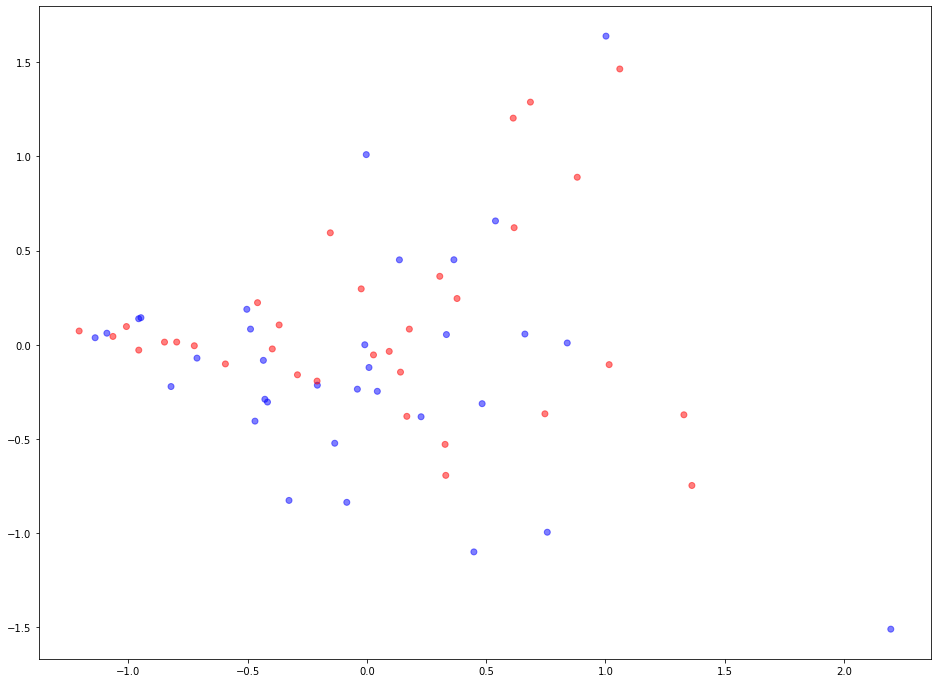

In [ ]:
# Calculate edge features for test data
link_features = link_examples_to_features(
    examples_test, embedding_test, best_result["binary_operator"]
)

# Learn a projection from 128 dimensions to 2
pca = PCA(n_components=2)
X_transformed = pca.fit_transform(link_features)

# plot the 2-dimensional points
plt.figure(figsize=(16, 12))
plt.scatter(
    X_transformed[:, 0],
    X_transformed[:, 1],
    c=np.where(labels_test == 1, "b", "r"),
    alpha=0.5,
)

## 7. Conclusions and Report <a name="report"></a>

In conclusion our project was an exploration of modelling polypharmacy using various framework available in the python coding language. We successfully used our ideas to generate conclusions such as most common side effects and their spread within our network, highest centrality measures,clsutering of graphs and perform some traditional graph learning models. Working with the “ChSe Decagon” data set increased our confidence when working with large datasets to create solutions for unique problems and as a group feel like the experience has improved our ability for future projects that require the use of such data sets. To conclude we found this project interesting and a little bit challenging due to the new ideas presented. 